In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Circle

In [26]:
def rigid_transform_3D(A, B):
    assert A.shape == B.shape

    num_rows, num_cols = A.shape
    if num_rows != 3:
        raise Exception(f"matrix A is not 3xN, it is {num_rows}x{num_cols}")

    num_rows, num_cols = B.shape
    if num_rows != 3:
        raise Exception(f"matrix B is not 3xN, it is {num_rows}x{num_cols}")

    # find mean column wise
    centroid_A = np.mean(A, axis=1)
    centroid_B = np.mean(B, axis=1)

    # ensure centroids are 3x1
    centroid_A = centroid_A.reshape(-1, 1)
    centroid_B = centroid_B.reshape(-1, 1)

    # subtract mean
    Am = A - centroid_A
    Bm = B - centroid_B

    H = Am @ np.transpose(Bm)

    # sanity check
    #if linalg.matrix_rank(H) < 3:
    #    raise ValueError("rank of H = {}, expecting 3".format(linalg.matrix_rank(H)))

    # find rotation
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T

    # special reflection case
    if np.linalg.det(R) < 0:
        print("det(R) < R, reflection detected!, correcting for it ...")
        Vt[2,:] *= -1
        R = Vt.T @ U.T

    t = -R @ centroid_A + centroid_B

    return R, t

old

In [27]:
positions = pd.read_csv('../data/povo-god/positions.csv')
predictions = pd.read_csv('../data/povo-1/predictions.csv')
targets = pd.read_csv('../data/povo-1/targets.csv')
A = '0001.png'
B = '0541.png'
C = '0999.png'

FileNotFoundError: [Errno 2] No such file or directory: '../data/povo-1/predictions.csv'

In [28]:
# corridoio lungo 127 px
#a = np.array([-0.149736, 0.425357, 0.667402])
#b = np.array([-0.80448, 0.492395, 0.14385])
# secondo tocco lungo 773px
px = 773
a = positions[positions.image == '0294.png'][['x','y','z']].squeeze()
b = positions[positions.image == '0774.png'][['x','y','z']].squeeze()
unit_measure = np.sqrt(np.sum((a - b)**2))
unit_measure

6.88059898267369

In [29]:
colmap_crs = positions[positions.image.isin([A, B, C])][['x','y','z']].values.T
cadatastral_crs = np.array([
    [1315, 850, 375],
    [100, 390, 150],
    [0, 0, 0]
])
colmap_crs = colmap_crs / unit_measure * px

In [30]:
# RA + t = B
R, t = rigid_transform_3D(colmap_crs, cadatastral_crs)
R, t

det(R) < R, reflection detected!, correcting for it ...


(array([[ 0.59381578, -0.17090702,  0.78624017],
        [-0.80453346, -0.13878746,  0.57746338],
        [ 0.01042773, -0.97546339, -0.2199146 ]]),
 array([[815.04683213],
        [ 95.38251366],
        [  1.38807858]]))

In [31]:
#points = positions[positions.image.isin(['0554.png', '0001.png', '0999.png'])][['x','y','z']].values.T
points = positions[['x','y','z']].values.T
points = points / unit_measure * px

predictions = predictions[['tx','ty','tz']].values.T
predictions = predictions / unit_measure * px

targets = targets[['tx','ty','tz']].values.T
targets = targets / unit_measure * px

D = (np.matmul(R, points) + t).T
F = (np.matmul(R, predictions) + t).T
G = (np.matmul(R, targets) + t).T

/tmp/ipykernel_21449/1245859220.py:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  predictions = predictions[['tx','ty','tz']].values.T


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

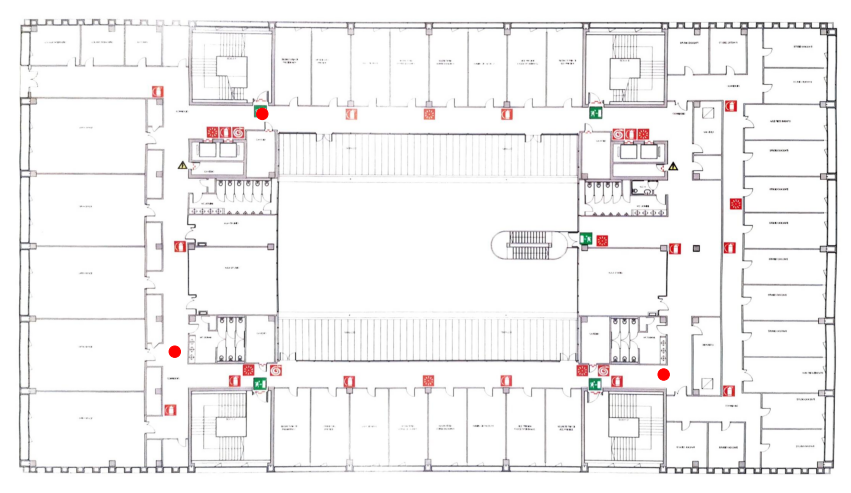

In [32]:
cadatastral_crs = np.array([
    [670, 440, 1725],
    [280, 905, 965],
    [0, 0, 0]
])

img = plt.imread('../camera-pose-estimation/model/static/cadatastral_plan_all.jpg')
fig, ax = plt.subplots(1, figsize=(15,15))
ax.set_aspect('equal')
ax.axis('off')

ax.imshow(img)
#for p in D: 
#    circ = Circle((p[0], p[1]), 7)
#    ax.add_patch(circ)
#for p in F: 
#    circ = Circle((p[0], p[1]), 7, color='orange')
#    ax.add_patch(circ)
#for p in G: 
#    circ = Circle((p[0], p[1]), 7, color='green')
#    ax.add_patch(circ)
for p in cadatastral_crs.T: 
    circ = Circle((p[0], p[1]), 15, color='red')
    ax.add_patch(circ)

new

In [46]:
# meta porta corridoio lavagne fine: 0870
# porta anti incendio corridoio per andare verso il corridoio delle lavagne: 0538
# spigolo per girare a sinistra verso tavoloni 1366

# 632 centro angolo lavagne

In [47]:
positions = pd.read_csv('../data/povo-god/positions.csv')
predictions = pd.read_csv('../data/povo-god/predictions.csv')
targets = pd.read_csv('../data/povo-god/targets.csv')
A = '0538.png'
B = '0870.png'
C = '1366.png'

In [48]:
px = 630
a = positions[positions.image == '0632.png'][['x','y','z']].squeeze()
b = positions[positions.image == '0891.png'][['x','y','z']].squeeze()
unit_measure = np.sqrt(np.sum((a - b)**2))
unit_measure

4.22608635945641

In [49]:
colmap_crs = positions[positions.image.isin([A, B, C])][['x','y','z']].values.T
cadatastral_crs = np.array([
    [690, 430, 1715],
    [280, 895, 1050],
    [0, 0, 0]
])
colmap_crs = colmap_crs / unit_measure * px

In [50]:
# RA + t = B
R, t = rigid_transform_3D(colmap_crs, cadatastral_crs)
R, t

(array([[ 0.09043424,  0.21994528, -0.97131134],
        [-0.99584784,  0.00975923, -0.09050882],
        [-0.01042773,  0.97546339,  0.2199146 ]]),
 array([[1080.31885417],
        [ 652.52917988],
        [  -1.84188703]]))

In [51]:
#points = positions[positions.image.isin(['0554.png', '0001.png', '0999.png'])][['x','y','z']].values.T
points = positions[['x','y','z']].values.T
points = points / unit_measure * px

predictions = predictions[['tx','ty','tz']].values.T
predictions = predictions / unit_measure * px

targets = targets[['tx','ty','tz']].values.T
targets = targets / unit_measure * px

D = (np.matmul(R, points) + t).T
F = (np.matmul(R, predictions) + t).T
G = (np.matmul(R, targets) + t).T

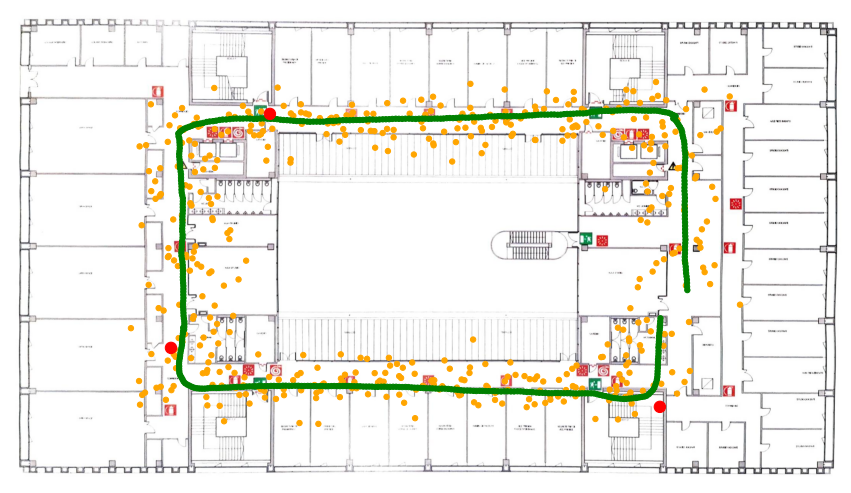

In [52]:
img = plt.imread('../camera-pose-estimation/model/static/cadatastral_plan_all.jpg')
fig, ax = plt.subplots(1, figsize=(15,15))
ax.set_aspect('equal')
ax.axis('off')

ax.imshow(img)
#for p in D: 
#    circ = Circle((p[0]*1, p[1]*0.95+15), 7)
#    ax.add_patch(circ)
for p in F: 
    circ = Circle((p[0], p[1]), 7, color='orange')
    ax.add_patch(circ)
for p in G: 
    circ = Circle((p[0], p[1]), 7, color='green')
    ax.add_patch(circ)
for p in cadatastral_crs.T: 
    circ = Circle((p[0], p[1]), 15, color='red')
    ax.add_patch(circ)